##**Image** **Classification** **using** **pre**-**trained** **models**

In [ ]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification")

In [2]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from torch.optim import Adam # Adam Optimizer
import torchvision.transforms as transforms # Transform function used to modify and preprocess all the images
from torchvision import models # import pretrained models in PyTorch library
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
from PIL import Image # Used to read the images from the directory
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory

In [3]:
train_df = pd.read_csv("/content/bean-leaf-lesions-classification/train.csv")
val_df = pd.read_csv("/content/bean-leaf-lesions-classification/val.csv")

In [4]:
train_df.head()

,image:FILE,category
0,train/healthy/healthy_train.98.jpg,0
1,train/healthy/healthy_train.148.jpg,0
2,train/healthy/healthy_train.306.jpg,0
3,train/healthy/healthy_train.305.jpg,0
4,train/healthy/healthy_train.40.jpg,0


In [5]:
print(train_df.shape)
print(val_df.shape)


(1034, 2)
(133, 2)


In [6]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
    ])

In [7]:
from pandas.core.frame import DataFrame
class CustomImageDataset(Dataset):
  def __init__(self,Dataframe,Transform) -> None:
    self.Dataframe = Dataframe
    self.Transform = Transform
    self.labels = torch.tensor(Dataframe['category'])

  def __len__(self):
    return self.Dataframe.shape[0]

  def __getitem__(self, index):
    img_path = os.path.join('./bean-leaf-lesions-classification/', self.Dataframe.iloc[index,0])
    image = Image.open(img_path).convert('RGB')
    label = self.labels[index]
    if self.Transform:
      image = (self.Transform(image)/255.0)
    return image , label

In [8]:
train_dataset = CustomImageDataset(Dataframe=train_df,Transform=transform)
val_dataset = CustomImageDataset(Dataframe=val_df,Transform=transform)

In [9]:
LR = 1e-3
BATCH_SIZE = 4
EPOCHS = 15

In [10]:
train_loader = DataLoader(train_dataset)
val_loader = DataLoader(val_dataset)

In [11]:
model = models.googlenet(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


100%|██████████| 49.7M/49.7M [00:00<00:00, 119MB/s]


In [12]:
for param in model.parameters():
  param.requires_grad = True

In [13]:
model.fc

Linear(in_features=1024, out_features=1000, bias=True)

In [14]:
classes = len(train_df['category'].unique())##checking how many categorys are available
classes

3

In [15]:
model.fc = torch.nn.Linear(model.fc.in_features,classes)
model.fc

Linear(in_features=1024, out_features=3, bias=True)

In [22]:
#Training
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(),lr=LR)

train_loss_plot = []
train_acc_plot = []

for epoch in range(EPOCHS):
  total_train_loss = 0
  total_train_acc = 0

  for inputs , labels in train_loader:
    optimizer.zero_grad()
    output = model(inputs)
    train_loss = loss_function(output,labels)
    total_train_loss +=train_loss.item()

    train_loss.backward()

    train_acc = (torch.argmax(output,axis = 1)==labels).sum().item()
    total_train_acc+=train_acc

    optimizer.step()

  train_loss_plot.append(round(total_train_loss/1000,4))
  train_acc_plot.append(round((total_train_acc/train_dataset.__len__())*100,4))
  print(f'Epoch {epoch+1}/2, Train Loss: {round(total_train_loss/100, 4)} Train Accuracy {round((total_train_acc)/train_dataset.__len__() * 100, 4)}%')
  print()

Epoch 1/2, Train Loss: 2.4611 Train Accuracy 95.1644%

Epoch 2/2, Train Loss: 1.6426 Train Accuracy 96.8085%

Epoch 3/2, Train Loss: 1.9014 Train Accuracy 95.8414%

Epoch 4/2, Train Loss: 2.3081 Train Accuracy 94.5841%

Epoch 5/2, Train Loss: 2.9102 Train Accuracy 92.94%

Epoch 6/2, Train Loss: 2.1964 Train Accuracy 94.7776%

Epoch 7/2, Train Loss: 1.6602 Train Accuracy 96.8085%

Epoch 8/2, Train Loss: 2.1473 Train Accuracy 95.1644%

Epoch 9/2, Train Loss: 2.3826 Train Accuracy 94.7776%

Epoch 10/2, Train Loss: 2.8068 Train Accuracy 93.1335%

Epoch 11/2, Train Loss: 2.4777 Train Accuracy 94.3907%

Epoch 12/2, Train Loss: 1.8337 Train Accuracy 96.1315%

Epoch 13/2, Train Loss: 2.5236 Train Accuracy 94.1006%

Epoch 14/2, Train Loss: 3.005 Train Accuracy 92.8433%

Epoch 15/2, Train Loss: 2.522 Train Accuracy 94.5841%



In [23]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0

  for inputs , labels in val_loader:
    output = model(inputs)
    acc = (torch.argmax(output, axis = 1) == labels).sum().item() # Use 'output' for argmax
    total_acc_test += acc


  print(f"Accuracy is {round(total_acc_test/val_dataset.__len__()*100,4)} ")

Accuracy is 33.8346 


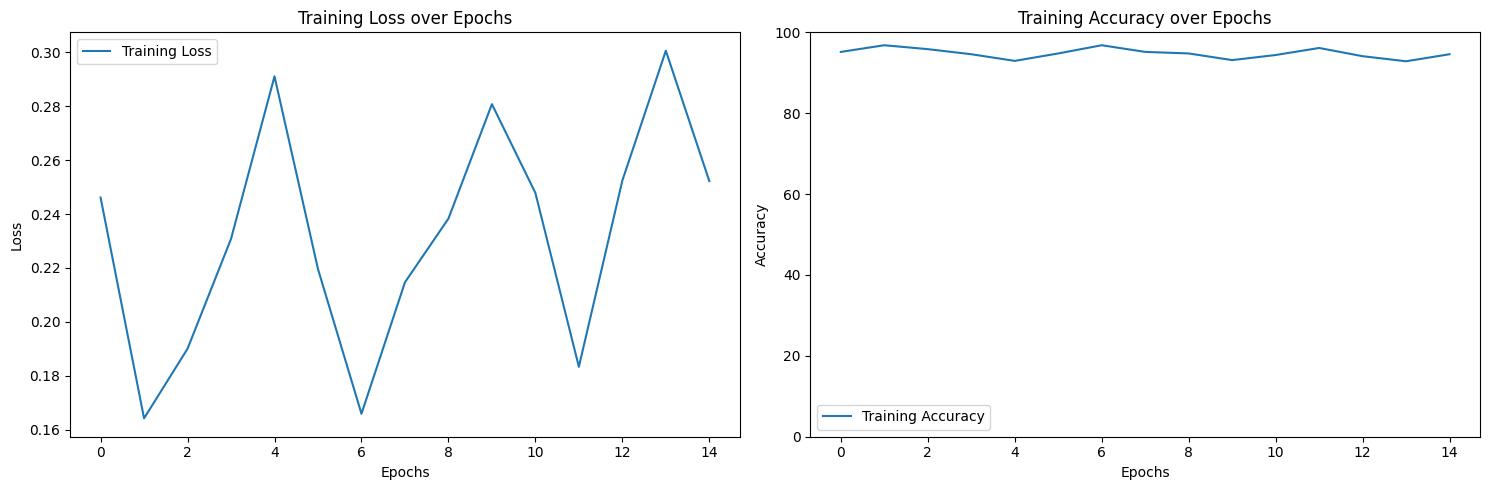

In [24]:

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(train_loss_plot , label='Training Loss')
axs[0].set_title('Training Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(train_acc_plot , label='Training Accuracy')
axs[1].set_title('Training Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()